<h1 align="center">Inpainting</h1> 

In [1]:
from PIL import Image
import lovely_tensors as lt
from omegaconf import OmegaConf
import torch
import numpy as np
import matplotlib.pyplot as plt 
from einops import repeat

from ldm.modules.encoders.modules import FrozenOpenCLIPEmbedder
from ldm.modules.diffusionmodules.openaimodel import UNetModel
from ldm.models.autoencoder import AutoencoderKL

from helper import ForwardDiffusionProcessor, X2imgs, imgs2X

lt.monkey_patch()

/home/chris/miniconda3/envs/stable-diffusion/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module 'xformers'. Proceeding without it.


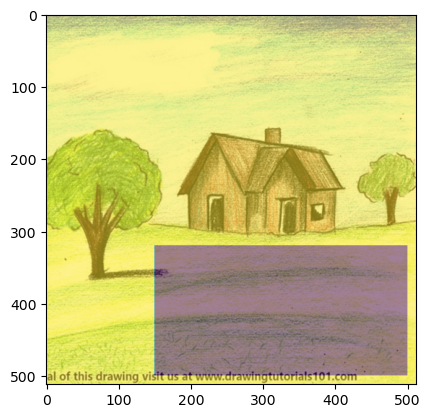

In [2]:
# open the image drawing.jpg and convert it into a numpy array
seed_img_path = "data/drawing.jpg"
# seed_img_path = "data/drawing2.jpg"
# seed_img_path = "data/scetch.jpg"

seed_img = np.array(Image.open(seed_img_path).resize((512,512)))
mask = np.ones(seed_img.shape[:2], dtype=np.float32)
# mask[150:400, 180:420] = 0
mask[320:500, 150:500] = 0

plt.imshow(seed_img)
plt.imshow(255*mask, alpha= 0.5)
plt.show()


In [3]:
# laod the weights

ckpt = "v2-1_512-ema-pruned.ckpt"
state_dict = torch.load(ckpt, map_location="cpu")["state_dict"]

state_dict_vae = {}
state_dict_unet = {}
state_dict_clip_embedder = {}

for k, v in state_dict.items():
    if k.startswith("first_stage_model."):
        state_dict_vae[k.replace("first_stage_model.", "")] = v
    elif k.startswith("model.diffusion_model."):
        state_dict_unet[k.replace("model.diffusion_model.", "")] = v
    elif k.startswith("cond_stage_model."):
        state_dict_clip_embedder[k.replace("cond_stage_model.", "")] = v
    else:
        pass

In [4]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# load the parameters
config_path = "../stablediffusion-repo/configs/stable-diffusion/v2-inference.yaml"
cfg = OmegaConf.load(config_path)

# load the variational autoencoder
vae = AutoencoderKL(**cfg.model.params.first_stage_config.params)
vae.load_state_dict(state_dict_vae, strict=True)
vae.to(device)
vae.eval()

# load the ddpm (denoising diffusion probabilistic model)
unet = UNetModel(**cfg.model.params.unet_config.params)
unet.load_state_dict(state_dict_unet, strict=True)
unet.to(device)
unet.eval()

# load the clip embedder
clip_embedder = FrozenOpenCLIPEmbedder(**cfg.model.params.cond_stage_config.params)
clip_embedder.load_state_dict(state_dict_clip_embedder, strict=True)
clip_embedder.to(device)
clip_embedder.eval()

pass

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [5]:
# Load a ForwardDiffusionProcessor, which is needed to get the corresponding
# alhpa values for out denoising process.
fdp = ForwardDiffusionProcessor()

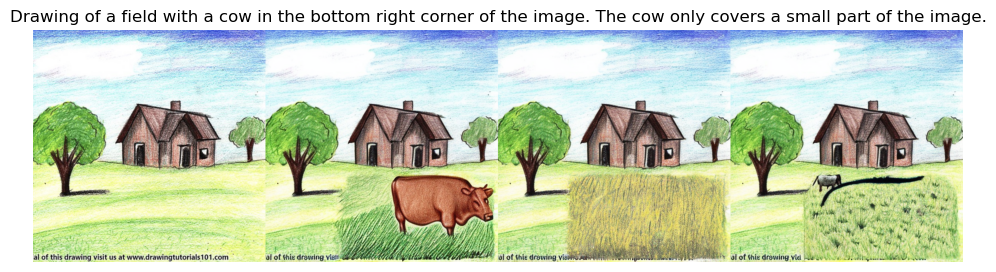

In [6]:
# Set the random seed to get reproducible results.
torch.manual_seed(0)

# Parameters
prompt = "Drawing of a field with a cow in the bottom right corner of the image. The cow only covers a small part of the image." 

n_steps = 100
guidance_scale = 7
batch_size = 3

# Generate a random noise to start the denoising process with.
embedding_shape = (batch_size, 4, 64, 64)
Z = torch.randn(embedding_shape).to(device)

# Generate the prompt embedding. Because we are using classifier-free guidance,
# we need to generate two embedding, i.e. the embedding of our prompt and the
# embedding of the unconditioned prompt.
with torch.no_grad():
    C = clip_embedder(batch_size * [prompt])
    C_unconditioned = clip_embedder(batch_size * [""])

# Generate the timesteps.
timesteps = fdp.get_timesteps(n_steps)

# Denoise the image.
with torch.no_grad(), torch.cuda.amp.autocast():    

    # for ts in timesteps[::-1]:
    for i in reversed(range(n_steps)):

        ts = timesteps[i]
        ts_prev = timesteps[i - 1] if i > 0 else ts        
        print(f"{i:>4} | ts={ts:<3} -> ts_prev={ts_prev:<3}", end="\r")

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Modify Z, i.e. overwrite the current Z with the corresponding Z_orig
        # from the seed image.
        
        # Encode the seed image and rescale to that we can use it for diffusion
        # denoising.
        X_orig = imgs2X(seed_img[np.newaxis, ...], device)
        posterior = vae.encode(X_orig)
        Z_orig = posterior.sample()
        Z_orig = Z_orig * cfg.model.params.scale_factor
        Z_orig = torch.cat([Z_orig]*batch_size)
        
        # "Encode" the mask, which basically means downsampling it.
        M = torch.from_numpy(mask[np.newaxis, np.newaxis, :,:])
        M = repeat(M.to(device=device), "1 1 ... -> n m ...", n=batch_size, m=4)
        M = torch.nn.functional.interpolate(M, size=Z_orig.shape[-2:] )

        # Diffuse the Z_orig to the current timestep.
        Z_orig = fdp.defuse_sample(Z_orig.cpu().numpy(), ts)
        Z_orig = torch.from_numpy(Z_orig.astype(np.float32)).to(device)

        # Merge Z_orig and Z.
        Z = Z_orig * M + Z * (1 - M)
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        # Encode the timestep.
        TS = torch.full((batch_size,), ts, device=device, dtype=torch.long)

        # Estimate the noise on the image. We do this twice, once conditioned on
        # the prompt and once unconditioned.
        EPS, EPS_unconditioned = unet(
            torch.cat([Z] * 2), 
            torch.cat([TS] * 2), 
            torch.cat([C, C_unconditioned])
            ).chunk(2)

        # Combine the predicted conditioned and unconditioned noise to guide the
        # denoising process.
        EPS = EPS_unconditioned + guidance_scale * (EPS - EPS_unconditioned)

        # Calculate the denoised image. The corresponding formula can be found
        # in the following paper or in the blog post from Lilian Weng:
        # - https://arxiv.org/abs/2010.02502
        # - https://lilianweng.github.io/posts/2021-07-11-diffusion-models/    
        alpha_bar = torch.full((batch_size, 1, 1, 1), fdp.get_alpha_bar(ts), device=device)
        alpha_bar_prev = torch.full((batch_size, 1, 1, 1), fdp.get_alpha_bar(ts_prev), device=device)
        Z = alpha_bar_prev.sqrt() * (Z - (1 - alpha_bar).sqrt()*EPS) / alpha_bar.sqrt() + (1-alpha_bar_prev).sqrt() * EPS
        

    # Decode the latent vector to get the final image.      
    Z_ = 1.0 / cfg.model.params.scale_factor * Z
    X = vae.decode(Z_)
    imgs = X2imgs(X)    
    
plt.figure(figsize=(batch_size*4, 4))
seed_and_imgs = np.vstack([seed_img[np.newaxis, ...], imgs])
plt.imshow(np.hstack(seed_and_imgs))
plt.axis("off")
plt.title(prompt)
plt.show()